In [7]:
# Install transformers if not already installed
# !pip install transformers torch

import pandas as pd
import numpy as np
import torch
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [8]:
# Load the clean reviews from Task 1
df = pd.read_csv("../data/processed/clean_reviews.csv")

# Quick check
df.head()


,review,rating,date,bank,source,clean_review,slow,crash,login,error,bug,transfer,fail,sentiment
0,maaliif daddafee install gaafata,3,2025-11-28,Commercial Bank of Ethiopia,Google Play Store,maaliif daddafee install gaafata,False,False,False,False,False,False,False,Neutral
1,good app,5,2025-11-28,Commercial Bank of Ethiopia,Google Play Store,good app,False,False,False,False,False,False,False,Positive
2,This application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,application important advantage transfer money...,False,False,False,False,False,True,False,Positive
3,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,work app,False,False,False,False,False,False,False,Negative
4,The app makes our life easier. Thank you CBE!,5,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,app makes life easier thank cbe,False,False,False,False,False,False,False,Positive


In [9]:
# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", 
                              model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to get sentiment label and score
def get_sentiment(text):
    text = str(text)
    if not text.strip():
        return {"label": "NEUTRAL", "score": 0.0}
    result = sentiment_pipeline(text[:512])[0]  # truncate long reviews
    # Normalize label
    label = result['label'].lower()
    score = result['score']
    if label == 'negative':
        score = -score  # negative scores for easier aggregation
    return {"label": label, "score": score}

# Apply to dataframe (this will take some time)
sentiments = df['clean_review'].apply(get_sentiment)

# Split dicts into separate columns
df['sentiment_label'] = sentiments.apply(lambda x: x['label'])
df['sentiment_score'] = sentiments.apply(lambda x: x['score'])

df.head()


Device set to use cpu


,review,rating,date,bank,source,clean_review,slow,crash,login,error,bug,transfer,fail,sentiment,sentiment_label,sentiment_score
0,maaliif daddafee install gaafata,3,2025-11-28,Commercial Bank of Ethiopia,Google Play Store,maaliif daddafee install gaafata,False,False,False,False,False,False,False,Neutral,negative,-0.987553
1,good app,5,2025-11-28,Commercial Bank of Ethiopia,Google Play Store,good app,False,False,False,False,False,False,False,Positive,positive,0.999849
2,This application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,application important advantage transfer money...,False,False,False,False,False,True,False,Positive,positive,0.732492
3,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,work app,False,False,False,False,False,False,False,Negative,positive,0.978127
4,The app makes our life easier. Thank you CBE!,5,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,app makes life easier thank cbe,False,False,False,False,False,False,False,Positive,positive,0.998064


In [10]:
# Define theme keywords per bank
theme_keyword_map = {
    "UI & UX": ["ui", "interface", "design", "layout", "experience"],
    "Performance": ["slow", "lag", "crash", "loading", "performance", "transfer"],
    "Login & Security": ["login", "password", "fingerprint", "authentication"],
    "Customer Support": ["support", "help", "service", "response"],
    "Feature Requests": ["feature", "add", "update", "improve", "request"]
}

# Function to assign themes
def assign_themes(text, theme_map):
    text = str(text).lower()
    matched = [theme for theme, keywords in theme_map.items() if any(k in text for k in keywords)]
    return matched if matched else ["Other"]

# Apply theme assignment
df['identified_themes'] = df['clean_review'].apply(lambda t: assign_themes(t, theme_keyword_map))
df['primary_theme'] = df['identified_themes'].apply(lambda lst: lst[0])

df.head()


,review,rating,date,bank,source,clean_review,slow,crash,login,error,bug,transfer,fail,sentiment,sentiment_label,sentiment_score,identified_themes,primary_theme
0,maaliif daddafee install gaafata,3,2025-11-28,Commercial Bank of Ethiopia,Google Play Store,maaliif daddafee install gaafata,False,False,False,False,False,False,False,Neutral,negative,-0.987553,[Feature Requests],Feature Requests
1,good app,5,2025-11-28,Commercial Bank of Ethiopia,Google Play Store,good app,False,False,False,False,False,False,False,Positive,positive,0.999849,[Other],Other
2,This application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,application important advantage transfer money...,False,False,False,False,False,True,False,Positive,positive,0.732492,[Performance],Performance
3,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,work app,False,False,False,False,False,False,False,Negative,positive,0.978127,[Other],Other
4,The app makes our life easier. Thank you CBE!,5,2025-11-27,Commercial Bank of Ethiopia,Google Play Store,app makes life easier thank cbe,False,False,False,False,False,False,False,Positive,positive,0.998064,[Other],Other


In [11]:
# Save results for Task 2
df.to_csv("../data/processed/sentiment_themes.csv", index=False)
print("Task 2 data saved: sentiment_themes.csv")


Task 2 data saved: sentiment_themes.csv


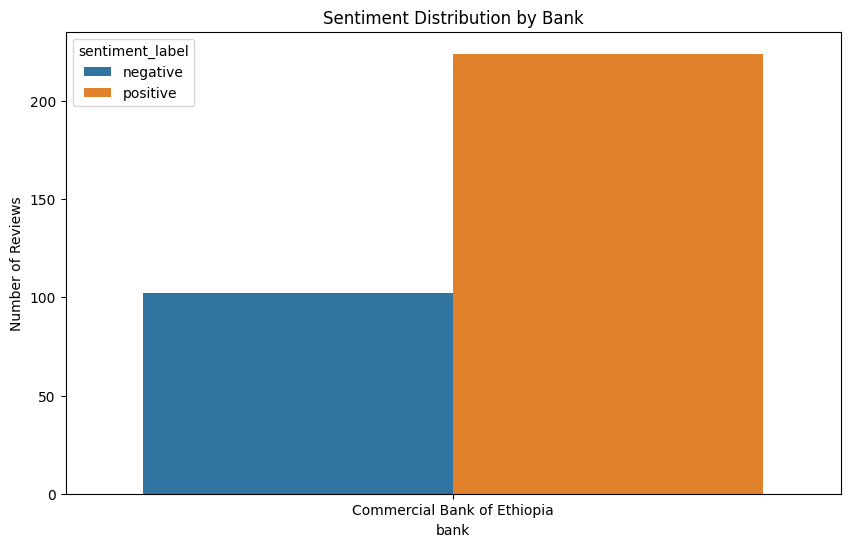

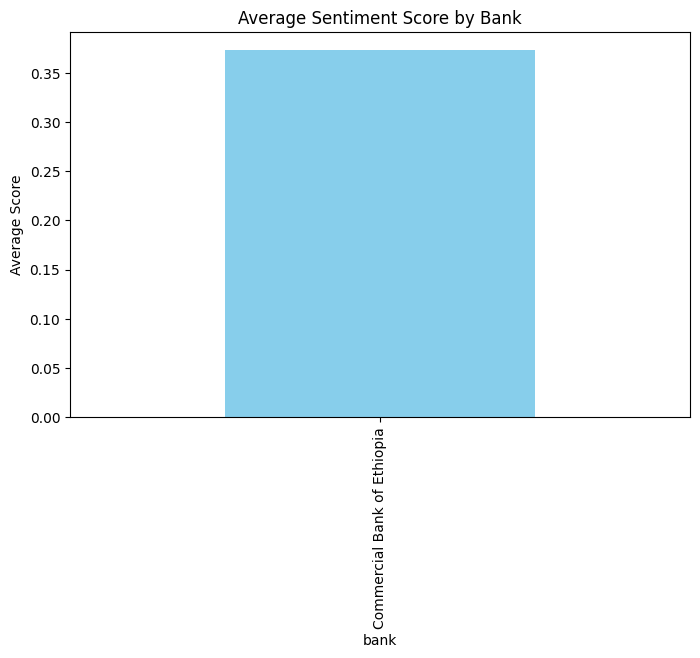

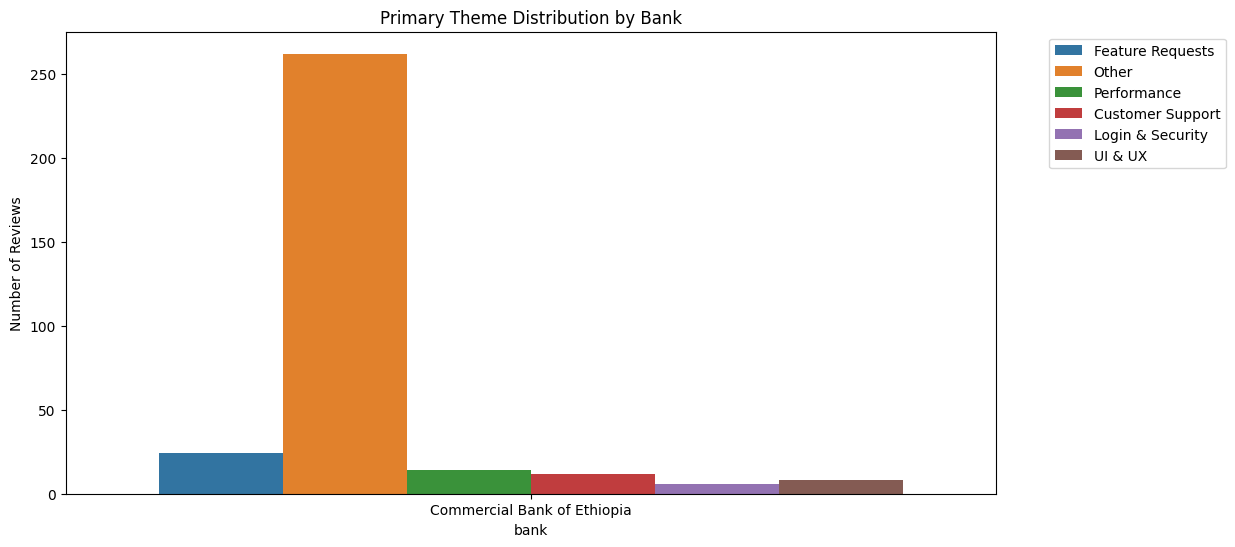

In [12]:
# Sentiment distribution by bank
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='bank', hue='sentiment_label')
plt.title("Sentiment Distribution by Bank")
plt.ylabel("Number of Reviews")
plt.show()

# Average sentiment score by bank
avg_sentiment = df.groupby('bank')['sentiment_score'].mean()
plt.figure(figsize=(8,5))
avg_sentiment.plot(kind='bar', color='skyblue')
plt.title("Average Sentiment Score by Bank")
plt.ylabel("Average Score")
plt.show()

# Theme distribution by bank
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='bank', hue='primary_theme')
plt.title("Primary Theme Distribution by Bank")
plt.ylabel("Number of Reviews")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_3544\2820155019.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='sentiment_score', data=df, palette='Set3')


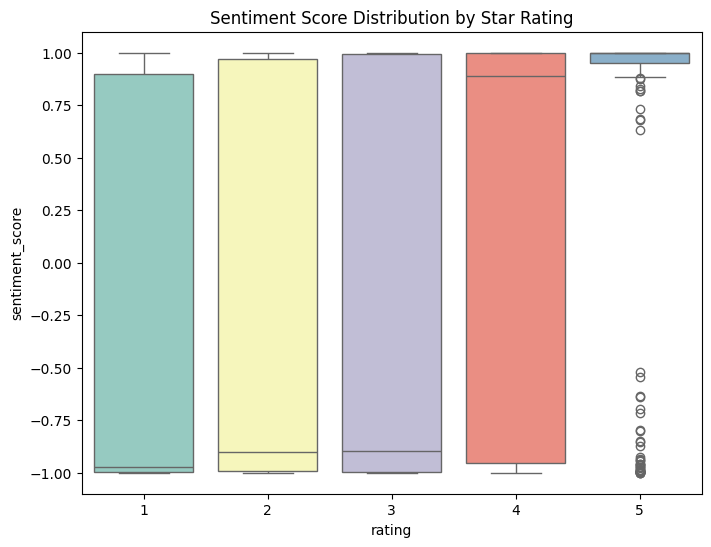

In [ ]:
#this is for the visualization of sentiment distribution of the banks reviews
plt.figure(figsize=(8,6))
sns.boxplot(x='rating', y='sentiment_score', data=df, palette='Set3')
plt.title("Sentiment Score Distribution by Star Rating")
plt.show()


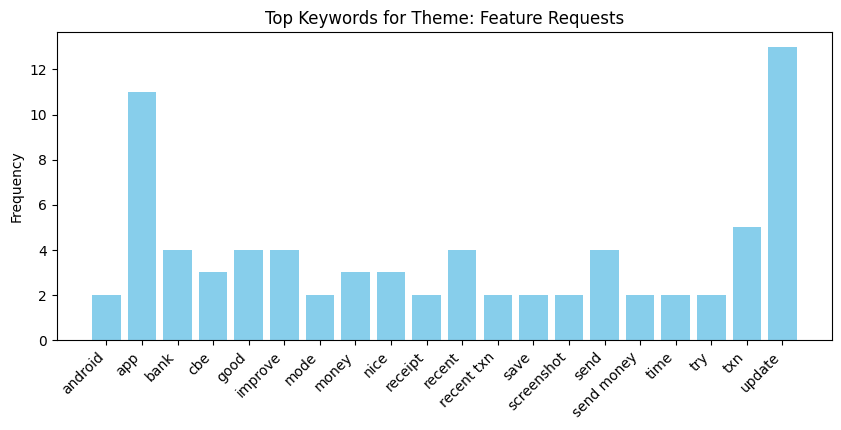

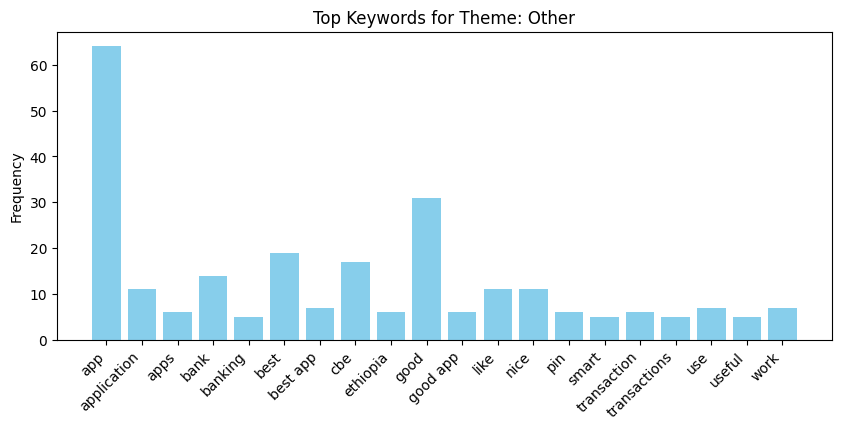

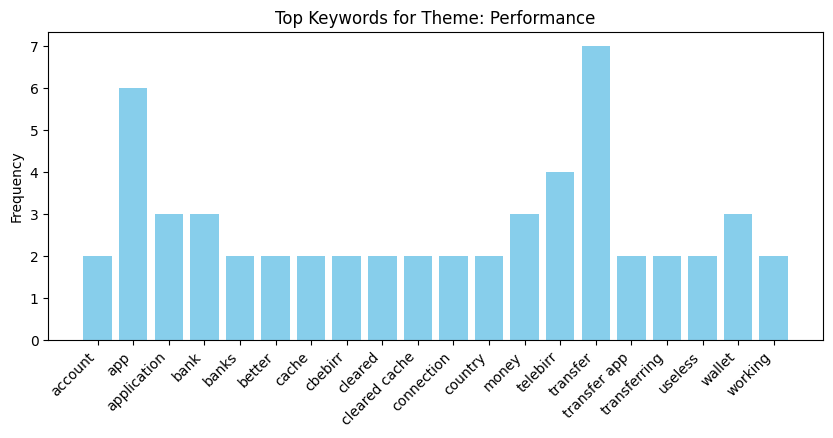

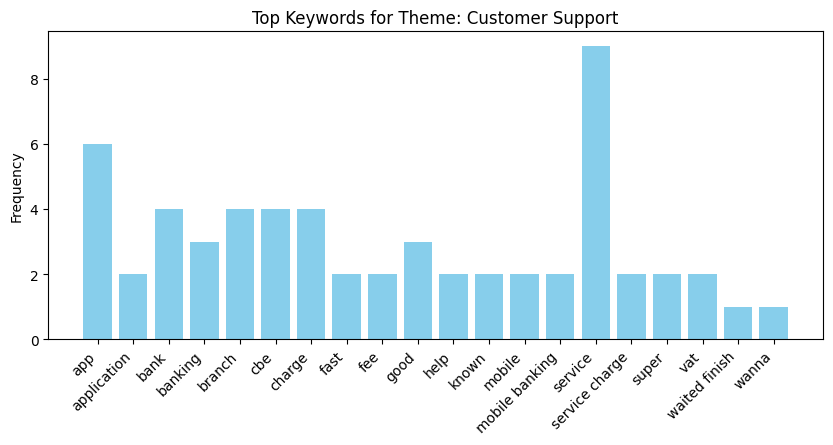

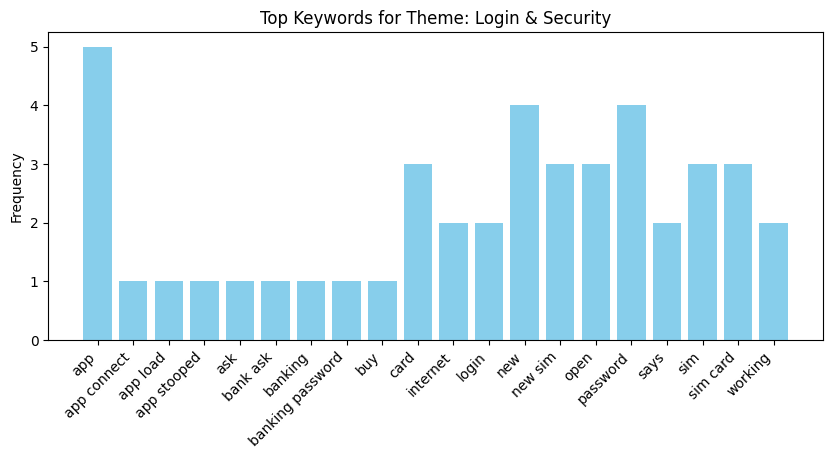

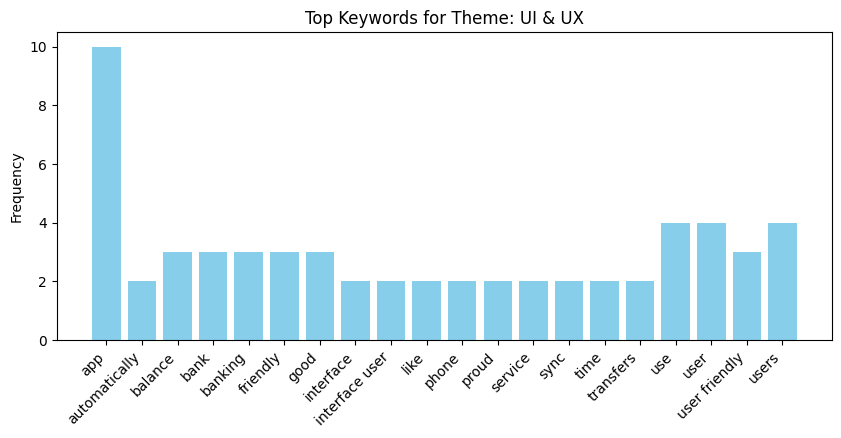

In [ ]:
#this is for the visualization of top keywords per theme
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Example: Top keywords per theme
themes = df['primary_theme'].unique()

for theme in themes:
    subset = df[df['primary_theme'] == theme]['clean_review'].dropna()  # <-- drop NaNs
    if len(subset) == 0:
        continue  # skip if no reviews for this theme

    vec = CountVectorizer(max_features=20, stop_words='english', ngram_range=(1,2))
    X = vec.fit_transform(subset)
    words = vec.get_feature_names_out()
    counts = X.toarray().sum(axis=0)
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top Keywords for Theme: {theme}")
    plt.ylabel("Frequency")
    plt.show()


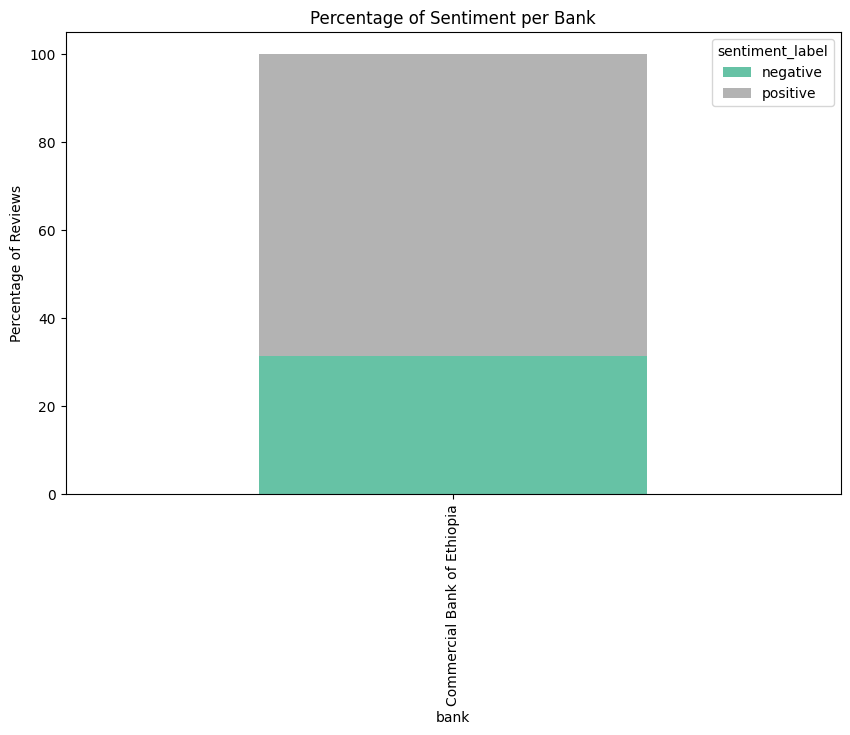

In [17]:
# Percentage of positive/negative/neutral reviews per bank
sentiment_pct = df.groupby('bank')['sentiment_label'].value_counts(normalize=True).unstack().fillna(0) * 100

sentiment_pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title("Percentage of Sentiment per Bank")
plt.ylabel("Percentage of Reviews")
plt.show()


<Figure size 1200x600 with 0 Axes>

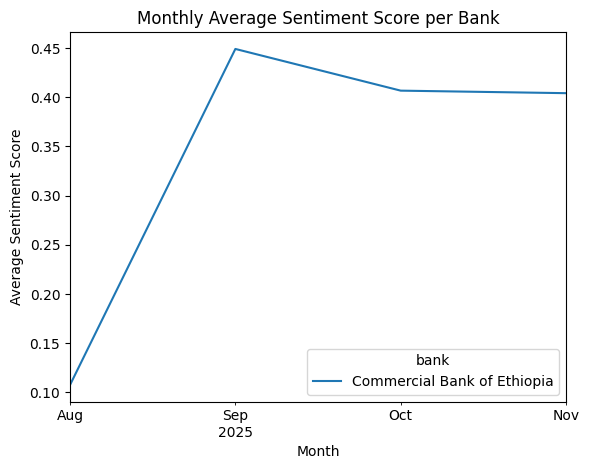

In [16]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

plt.figure(figsize=(12,6))
df.groupby([df['date'].dt.to_period('M'),'bank'])['sentiment_score'].mean().unstack().plot()
plt.title("Monthly Average Sentiment Score per Bank")
plt.ylabel("Average Sentiment Score")
plt.xlabel("Month")
plt.show()


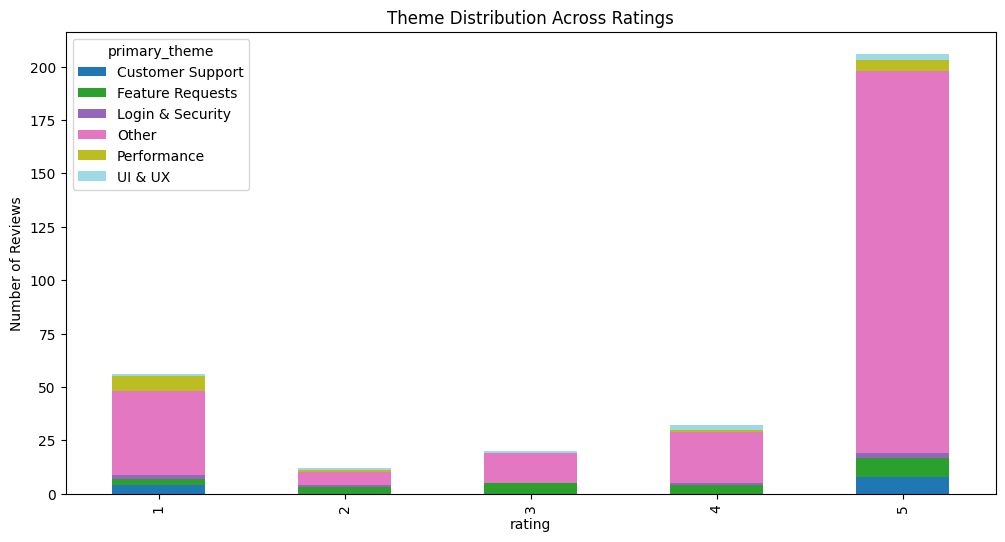

In [ ]:
#this is for the visualization of theme distribution across ratings
theme_rating_counts = df.groupby(['rating','primary_theme']).size().unstack(fill_value=0)

theme_rating_counts.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title("Theme Distribution Across Ratings")
plt.ylabel("Number of Reviews")
plt.show()
